In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

import optuna
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, AUC, PR_curve, multiple_curve, \
    best_threshold

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

In [2]:
##### GPU ??? #####
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device.'.format(device))

Using cpu device.


### Dataloader

In [3]:
class RunhistSet(Dataset):
    
    def __init__(self, train_x, train_y):
        self.x = torch.tensor(train_x.values.astype(np.float32))
        self.y = torch.tensor(train_y.values.astype(np.float32)).long()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

### Neural Network

In [30]:
class NeuralNetworkC(nn.Module):
    
    def __init__(self, dim):
        super(NeuralNetworkC, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
#             nn.Linear(96, 32),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.Linear(64, 16),
#             nn.ReLU(),
#             nn.Dropout(0.25),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits
    
    
class NeuralNetworkR(nn.Module):
    
    def __init__(self):
        super(NeuralNetworkR, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(114, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.25),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Dropout(0.25),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

### label smoothing

In [5]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim                                                                                                                                                                                                                                                                                                                                                                                                                                              

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

### training

In [6]:
def trainingC(network, trainloader, validloader, optimizer, criterion, epoch, filename, early_stop):
    
    network.train()
    best_model = network
    best_objective = 0
    stop_trigger = 0
    train_loss = []
    valid_loss = []
    
    for i in tqdm(range(epoch)):
        
        total_loss = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0  
        for x, y in trainloader:
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = network(x)
            loss = criterion(output, y)         
            
            _, predicted = torch.max(output.data, 1)
            TP += torch.dot((predicted == y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
            TN += torch.dot((predicted == y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
            FN += torch.dot((predicted != y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
            FP += torch.dot((predicted != y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
            total_loss += loss.item()*len(y)
            loss.backward()
            optimizer.step()
        
        train_loss.append(total_loss)
        recall = TP / (TP + FN)
        aging = (TP + FP) / (TP + TN + FP + FN)
            
        print(f'Epoch {i+1}: Train Loss = {total_loss / (TP + TN + FP + FN)}, Recall = {recall}, Aging Rate = {aging}')
        
        if ((i+1) % 5 == 0):
            five_loss, valid_recall, _ = testingC(network, validloader, criterion)
            valid_loss.append(five_loss)
            
            if valid_recall > best_objective:
                best_objective = valid_recall
                best_model = network
                torch.save(best_model, f'{filename}_NeuralNetworkC_{epoch}.ckpt')
                print(f'Model in epoch {i+1} is saved.\n')
                stop_trigger = 0
            else:
                stop_trigger += 1
                print('')
                
            if stop_trigger == early_stop:
                print(f'Training Finished at epoch {i+1}.')
                return network, train_loss, valid_loss
            
    return network, train_loss, valid_loss


def PR_matrix(predict):
    
    Y_new = predict.sort_values(['predict', 'truth'], ascending = [False, True]).reset_index(drop = True)
    Y_new.loc[Y_new['truth'] != 1, 'truth'] = 0
    
    matrix = pd.DataFrame(Y_new.groupby('predict').sum()).rename(columns = {'truth': 'Bad_Count'})
    matrix = matrix.sort_index(ascending = False)
    matrix['All_Count'] = Y_new.groupby('predict').count()
    matrix['Class_Prob'] = matrix.index
    
    matrix['TP'] = matrix['Bad_Count'].cumsum()
    matrix['FP'] = matrix['All_Count'].cumsum() - matrix['TP']
    matrix['FN'] = matrix['TP'].values[-1] - matrix['TP']
    matrix['TN'] = matrix['FP'].values[-1] - matrix['FP']
    
    matrix['Precision'] = matrix['TP'] / (matrix['TP'] + matrix['FP'])
    matrix['Recall'] = matrix['TP'] / (matrix['TP'] + matrix['FN'])
    matrix['Aging Rate'] = (matrix['TP'] + matrix['FP']) / (matrix['TP'] + matrix['FP'] + matrix['FN'] + matrix['TN'])
    matrix['Efficiency'] = matrix['Recall'] / matrix['Aging Rate']
    matrix['Score'] = score1(matrix['Recall'], matrix['Aging Rate'])            
    matrix = matrix.drop(columns = ['Bad_Count', 'All_Count']).reset_index(drop = True)
    
    return matrix


def trainingR(network, trainloader, validloader, optimizer, criterion, epoch, filename, early_stop):
    
    network.train()
    best_model = network
    best_objective = 1
    stop_trigger = 0
    train_loss = []
    valid_loss = []
    
    for i in tqdm(range(epoch)):
        
        total_loss = 0
        predict_vector = torch.tensor([0])
        y_vector = torch.tensor([0])
        for x, y in trainloader:
            
            x = x.to(device)
            y = y.type(torch.FloatTensor).to(device)
            y = y.unsqueeze(1)
            optimizer.zero_grad()
            output = network(x)
            loss = criterion(output, y)
            total_loss += loss.item()*len(y)
            loss.backward()
            optimizer.step()    
            predict_vector = torch.cat((predict_vector, output.data[:,0]), axis = 0)
            y_vector = torch.cat((y_vector, y[:,0]), axis = 0)       
        result_df = pd.DataFrame(dict(predict = predict_vector, truth = y_vector))
        pr_matrix = PR_matrix(result_df.iloc[1:, :])
        best_data, best_thres = best_threshold(pr_matrix, target = 'Recall', threshold = 0.7)
        auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
        train_loss.append(total_loss)
        
        recall = best_data["Recall"].values
        aging = best_data["Aging Rate"].values
        print(f'Epoch {i+1}: Train Loss = {total_loss}, AUC = {auc}, Recall(0.7) = {recall}, Aging Rate = {aging}')
        
        if ((i+1) % 5 == 0):
            five_loss, valid_auc, _ = testingR(network, validloader, criterion)
            valid_loss.append(five_loss)
            
            if valid_auc < best_objective:
                best_objective = valid_auc
                best_model = network
                torch.save(best_model, f'{filename}_NeuralNetworkR_{epoch}.ckpt')
                print(f'Model in epoch {i+1} is saved.\n')
                stop_trigger = 0
            else:
                stop_trigger += 1
                print('')
                
            if stop_trigger == early_stop:
                print(f'Training Finished at epoch {i+1}.')
                return network, train_loss, valid_loss
      
    return network, train_loss, valid_loss

### testing

In [68]:
def testingC(network, dataloader, criterion):
    
    network.eval()
    total_loss = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)
        output = network(x)
        loss = criterion(output, y)
        
        _, predicted = torch.max(output.data, 1)
        TP += torch.dot((predicted == y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
        TN += torch.dot((predicted == y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
        FN += torch.dot((predicted != y).to(torch.float32), (y == 1).to(torch.float32)).sum().item()
        FP += torch.dot((predicted != y).to(torch.float32), (y == 0).to(torch.float32)).sum().item()
        total_loss += loss.item()*len(y)
        
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    aging = (TP + FP) / (TP + TN + FP + FN)
    if (TP + FP) != 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
    if aging != 0:
        efficiency = recall / aging
        score = score1(recall, aging)
    else:
        efficiency = 0
        score = 0
        
    print(f'Test Loss = {total_loss / (TP + TN + FP + FN)}, Recall = {recall}, Aging Rate = {aging}, Efficiency = {recall / (aging + 1e-8)}')
    
    valid_objective = recall - 0.5*aging
    table = pd.Series({'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'Precision': precision, 'Recall': recall, 
                       'Aging Rate': aging, 'Efficiency': efficiency, 'Score': score})
    table = pd.DataFrame(table).T
    
    return total_loss, valid_objective, table


def testingR(network, dataloader, criterion):
    
    network.eval()   
    total_loss = 0
    predict_vector = torch.tensor([0])
    y_vector = torch.tensor([0])
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)
        y = y.unsqueeze(1)
        output = network(x)
        loss = criterion(output, y)
        total_loss += loss.item()*len(y)
        
        predict_vector = torch.cat((predict_vector, output.data[:,0]), axis = 0)
        y_vector = torch.cat((y_vector, y[:,0]), axis = 0)
    result_df = pd.DataFrame(dict(predict = predict_vector, truth = y_vector))
    pr_matrix = PR_matrix(result_df.iloc[1:, :])
    best_data, best_thres = best_threshold(pr_matrix, target = 'Recall', threshold = 0.7)
    auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
    recall = best_data['Recall'].values[0]
    aging = best_data['Aging Rate'].values[0]
    precision = best_data['Precision'].values[0]
    efficiency = best_data['Efficiency'].values[0]
    score = best_data['Score'].values[0]
    TP = best_data['TP'].values[0]
    FP = best_data['FP'].values[0]
    TN = best_data['TN'].values[0]
    FN = best_data['FN'].values[0]
        
    print(f'Test Loss = {total_loss}, Recall = {recall}, Aging Rate = {aging}, Efficiency = {efficiency}')
    
    valid_objective = auc
    table = pd.Series({'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, 'Precision': precision, 'Recall': recall,
                       'Aging Rate': aging,'Efficiency': efficiency, 'Score': score})
    table = pd.DataFrame(table).T
    
    return total_loss, valid_objective, table

### Run all datasets

In [8]:
def runall_nn(train_x, train_y, test_x, test_y, n_epoch, batch_size, model, optimizer, criterion, filename,
              train_ratio, early_stop, mode):
    
    set_name = list(train_x.keys())
    result_table = pd.DataFrame()
    train_dict = {}
    valid_dict = {}
    for num, i in enumerate(tqdm(set_name)):
        print(f'\nStarting training Dataset {num}:')
        
        # data preparation
        train_ratio = train_ratio
        train_data = RunhistSet(train_x[i], train_y[i])
        test_data = RunhistSet(test_x, test_y)
        train_size = int(len(train_data)*train_ratio)
        valid_size = len(train_data) - train_size
        train_data, valid_data = random_split(train_data, [train_size, valid_size])
        
        train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
        valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False)
        test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
        
        # training
        if mode == 'C':
            done_model, train_loss, valid_loss = trainingC(network = model, 
                                                           trainloader = train_loader, 
                                                           validloader = valid_loader, 
                                                           optimizer = optimizer, 
                                                           criterion = criterion, 
                                                           epoch = n_epoch, 
                                                           filename = filename, 
                                                           early_stop = early_stop)
        elif mode == 'R':
            done_model, train_loss, valid_loss = trainingR(network = model, 
                                                           trainloader = train_loader, 
                                                           validloader = valid_loader, 
                                                           optimizer = optimizer, 
                                                           criterion = criterion, 
                                                           epoch = n_epoch, 
                                                           filename = filename, 
                                                           early_stop = early_stop)
        train_dict[i] = train_loss
        valid_dict[i] = valid_loss
        
        # testing
        if mode == 'C':
            _, _, table = testingC(done_model, test_loader, criterion)
        elif mode == 'R':
            _, _, table = testingR(done_model, test_loader, criterion)
        result_table = pd.concat([result_table, table], axis = 0).rename({0: f'dataset {num}'})
    loss_dict = dict(train = train_dict, valid = valid_dict)
        
    return result_table, loss_dict


def loss_plot(train_loss, valid_loss, num_row, num_col):
    
    fig , axes = plt.subplots(num_row, num_col, sharex = False, sharey = False, figsize = (num_row*8 + 1, num_col*6))
    plt.suptitle('Training & Validation Loss Curve', y = 0.94, fontsize = 30)
    for row in range(num_row):
        for col in range(num_col):
            
            index = num_col*row + col
            if index < len(train_loss):
                
                train = train_loss[f'set{index}']
                valid = valid_loss[f'set{index}']
                axes[row, col].plot(range(len(train)), train, 'b-', linewidth = 5, label = 'train')
                axes[row, col].plot(range(4, len(train)+1, 5), valid, 'r-', linewidth = 5, label = 'valid')
                axes[row, col].set_xlabel('Epoch')
                axes[row, col].set_ylabel('Total Loss')
                axes[row, col].set_title(f'dataset {index}')
                axes[row, col].legend(loc = 'upper right', fancybox = True, prop = dict(size = 20))

## 

### loading training & testing data

In [9]:
### training data ### 
training_month = range(1, 7)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 1:

Dimension of dataset 0 : (17735, 84)  balance ratio: 1181.0
Dimension of dataset 1 : (296, 84)  balance ratio: 1.0
Dimension of dataset 2 : (420, 84)  balance ratio: 1.0
Dimension of dataset 3 : (328, 84)  balance ratio: 1.0
Dimension of dataset 4 : (300, 84)  balance ratio: 1.0
Dimension of dataset 5 : (298, 84)  balance ratio: 1.0
Dimension of dataset 6 : (370, 84)  balance ratio: 1.0
Dimension of dataset 7 : (300, 84)  balance ratio: 1.0
Dimension of dataset 8 : (300, 84)  balance ratio: 1.0
Dimension of dataset 9 : (165, 84)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 2:

Dimension of dataset 0 : (39009, 90)  balance ratio: 533.0
Dimension of dataset 1 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 2 : (1908, 90)  balance ratio: 1.0
Dimension of dataset 3 : (1604, 90)  balance ratio: 1.0
Dimension of dataset 4 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 5 : (1465, 90)  balance ratio: 1.0
Dimension of dataset

### For one dataset

In [10]:
##### data preparation #####
train_data = RunhistSet(run_train_x['set7'], run_train_y['set7'])
test_data = RunhistSet(run_test_x, run_test_y)
train_ratio = 0.75
train_size = int(len(train_data)*train_ratio)
valid_size = len(train_data) - train_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)

#### classifier

In [ ]:
##### model preparation #####
# hyperparameter: learning rate, weight decay, weight
modelC = NeuralNetworkC().to(device)
optimizerC = torch.optim.Adam(modelC.parameters(), lr = 0.001, weight_decay = 0.01)
criterionC = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 0.5])).to(device)

### label smoothing ###
#criterionC = LabelSmoothingLoss(classes = 2, smoothing = 0.2)

##### training #####
done_modelC, train_lossC, valid_lossC = trainingC(network = modelC, 
                                                  trainloader = train_loader, 
                                                  validloader = valid_loader, 
                                                  optimizer = optimizerC, 
                                                  criterion = criterionC, 
                                                  epoch = 150, 
                                                  filename = 'tamama',
                                                  early_stop = 10)

##### testing #####
_, _, result_tableC = testingC(done_modelC, test_loader, criterionC)

#### regressor

In [20]:
##### model preparation #####
# hyperparameter: learning rate, weight decay, weight
modelR = NeuralNetworkR().to(device)
optimizerR = torch.optim.Adam(modelR.parameters(), lr = 0.001, weight_decay = 0.001)
criterionR = nn.MSELoss().to(device)

##### training #####
done_modelR, train_lossR, valid_lossR = trainingR(network = modelR, 
                                                  trainloader = train_loader, 
                                                  validloader = valid_loader, 
                                                  optimizer = optimizerR, 
                                                  criterion = criterionR, 
                                                  epoch = 150, 
                                                  filename = 'tamama',
                                                  early_stop = 10)

##### testing #####
_, _, result_tableR = testingR(done_modelR, test_loader, criterionR)

  0%|          | 0/150 [00:00<?, ?it/s]

Best Threshold: 0.43432676792144775 

Recall: [0.70041752] ,   Precision: [0.63361662] ,   Aging Rate: [0.54517375]
Epoch 1: Train Loss = 846.9388972967863, AUC = 0.3952542841727463, Recall(0.7) = [0.70041752], Aging Rate = [0.54517375]
Best Threshold: 0.5488395690917969 

Recall: [0.70041752] ,   Precision: [0.94908062] ,   Aging Rate: [0.36396396]
Epoch 2: Train Loss = 518.1432443782687, AUC = 0.27935565393543216, Recall(0.7) = [0.70041752], Aging Rate = [0.36396396]
Best Threshold: 0.6151427626609802 

Recall: [0.70041752] ,   Precision: [0.98676471] ,   Aging Rate: [0.35006435]
Epoch 3: Train Loss = 382.7067674770951, AUC = 0.26039226766551476, Recall(0.7) = [0.70041752], Aging Rate = [0.35006435]
Best Threshold: 0.6658647656440735 

Recall: [0.70041752] ,   Precision: [0.99628805] ,   Aging Rate: [0.34671815]
Epoch 4: Train Loss = 303.71694777160883, AUC = 0.2535262898694735, Recall(0.7) = [0.70041752], Aging Rate = [0.34671815]
Best Threshold: 0.6969634890556335 

Recall: [0.7004

Best Threshold: 0.9722369313240051 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 32: Train Loss = 9.031352465739474, AUC = 0.24658951385088584, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9751859903335571 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 33: Train Loss = 8.162652850616723, AUC = 0.24658951382979027, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9743627309799194 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 34: Train Loss = 8.170216631609946, AUC = 0.24658951382211916, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9755672216415405 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 35: Train Loss = 8.700050393119454, AUC = 0.24658951382979027, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9651535153388977 

Recall: [0.70178042] ,   Precision: [1.] , 

Best Threshold: 0.9831069707870483 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 63: Train Loss = 5.964000734151341, AUC = 0.24658951382979027, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.982894778251648 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 64: Train Loss = 6.6053667610976845, AUC = 0.24658951382979027, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9815890789031982 

Recall: [0.70041752] ,   Precision: [1.] ,   Aging Rate: [0.34543115]
Epoch 65: Train Loss = 5.97409304860048, AUC = 0.24658951382787245, Recall(0.7) = [0.70041752], Aging Rate = [0.34543115]
Best Threshold: 0.9652794599533081 

Recall: [0.70029674] ,   Precision: [1.] ,   Aging Rate: [0.36447876]
Test Loss = 14.8444560226053, Recall = 0.7002967359050445, Aging Rate = 0.3644787644787645, Efficiency = 1.9213649851632046

Best Threshold: 0.9824767112731934 

Recall: [0.70041752] ,   Precision: [1.] ,

### For multiple datasets

#### classifier

In [77]:
runall_modelC = NeuralNetworkC(dim = 133).to(device)
runall_optimizerC = torch.optim.Adam(runall_modelC.parameters(), lr = 0.001, weight_decay = 0.01)
runall_criterionC = nn.CrossEntropyLoss(weight = torch.tensor([0.2, 0.8])).to(device)

table_setC, loss_dictC = runall_nn(train_x = run_train_x, 
                                   train_y = run_train_y, 
                                   test_x = run_test_x, 
                                   test_y = run_test_y, 
                                   n_epoch = 150, 
                                   batch_size = 64,
                                   model = runall_modelC,
                                   optimizer = runall_optimizerC, 
                                   criterion = runall_criterionC, 
                                   filename = 'runhist_array_m1m6_m7_3criteria_NeuralNetworkC', 
                                   train_ratio = 0.75, 
                                   early_stop = 10,
                                   mode = 'C')

  0%|          | 0/10 [00:00<?, ?it/s]


Starting training Dataset 0:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.05195593168263867, Recall = 0.0, Aging Rate = 0.0002651403803035281
Epoch 2: Train Loss = 0.04930674600282732, Recall = 0.0, Aging Rate = 0.0
Epoch 3: Train Loss = 0.04900512052182173, Recall = 0.0, Aging Rate = 0.0
Epoch 4: Train Loss = 0.0491876664311161, Recall = 0.0, Aging Rate = 0.0
Epoch 5: Train Loss = 0.04875879685507351, Recall = 0.0, Aging Rate = 0.0
Test Loss = 0.041577422972488655, Recall = 0.0, Aging Rate = 0.0, Efficiency = 0.0

Epoch 6: Train Loss = 0.048394555800856456, Recall = 0.0, Aging Rate = 0.0
Epoch 7: Train Loss = 0.04857432504067837, Recall = 0.0, Aging Rate = 0.0
Epoch 8: Train Loss = 0.04851370183075093, Recall = 0.0, Aging Rate = 0.0
Epoch 9: Train Loss = 0.04840678849536985, Recall = 0.0, Aging Rate = 0.0
Epoch 10: Train Loss = 0.048229019748548575, Recall = 0.0, Aging Rate = 0.0
Test Loss = 0.043955876181587424, Recall = 0.0, Aging Rate = 0.0, Efficiency = 0.0

Epoch 11: Train Loss = 0.04827040197834597, Recall = 0.0, Aging Rate = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.768496951441278, Recall = 0.8242595204513399, Aging Rate = 0.8078480659125821
Epoch 2: Train Loss = 0.3980089911592521, Recall = 0.9627644569816644, Aging Rate = 0.8031001256807708
Epoch 3: Train Loss = 0.3418382134097629, Recall = 0.9596614950634696, Aging Rate = 0.7342549923195084
Epoch 4: Train Loss = 0.32059768805322725, Recall = 0.9590973201692524, Aging Rate = 0.7142857142857143
Epoch 5: Train Loss = 0.30212615921650166, Recall = 0.9616361071932299, Aging Rate = 0.6972489875715682
Test Loss = 0.28433863756219163, Recall = 0.9715215622457283, Aging Rate = 0.6987850858818601, Efficiency = 1.3903009207998023
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2766706375515739, Recall = 0.9675599435825106, Aging Rate = 0.6775590001396453
Epoch 7: Train Loss = 0.26425977915030185, Recall = 0.9689703808180536, Aging Rate = 0.6661080854629242
Epoch 8: Train Loss = 0.2529164185372166, Recall = 0.9712270803949224, Aging Rate = 0.6584275939114649
Epoch 9: Train Loss

Epoch 63: Train Loss = 0.18173790336354387, Recall = 0.9875881523272214, Aging Rate = 0.6000558581203742
Epoch 64: Train Loss = 0.18049980472368063, Recall = 0.9881523272214386, Aging Rate = 0.6004747940231812
Epoch 65: Train Loss = 0.18039835424933282, Recall = 0.9870239774330042, Aging Rate = 0.596425080296048
Test Loss = 0.18604276190380398, Recall = 0.9877949552481693, Aging Rate = 0.6162547130289066, Efficiency = 1.602900421424981

Epoch 66: Train Loss = 0.179490212173689, Recall = 0.9892806770098731, Aging Rate = 0.5987990504119537
Epoch 67: Train Loss = 0.18045245186940634, Recall = 0.9887165021156559, Aging Rate = 0.5990783410138248
Epoch 68: Train Loss = 0.17880802007381386, Recall = 0.9878702397743301, Aging Rate = 0.5936321742773356
Epoch 69: Train Loss = 0.17896448011680316, Recall = 0.9901269393511989, Aging Rate = 0.5969836614997905
Epoch 70: Train Loss = 0.17872441616941973, Recall = 0.9887165021156559, Aging Rate = 0.5948889819857561
Test Loss = 0.18539340726041773, Rec

Test Loss = 1.11010107373705, Recall = 0.5405405405405406, Aging Rate = 0.5856439192470457, Efficiency = 0.9229849632958819

Starting training Dataset 2:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.35246378170701886, Recall = 0.9559011504047721, Aging Rate = 0.7701295942213724
Epoch 2: Train Loss = 0.32014235101018157, Recall = 0.9737963357477631, Aging Rate = 0.7724665391969407
Epoch 3: Train Loss = 0.31180031511189454, Recall = 0.9782701320835109, Aging Rate = 0.759613341831315
Epoch 4: Train Loss = 0.30949913189115863, Recall = 0.9789092458457606, Aging Rate = 0.7594008922880816
Epoch 5: Train Loss = 0.30603563069461487, Recall = 0.9821048146570089, Aging Rate = 0.7625876354365838
Test Loss = 0.2924421656048169, Recall = 0.9898862199747156, Aging Rate = 0.7820267686424475, Efficiency = 1.265795810334142
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.28332789335023933, Recall = 0.9853003834682573, Aging Rate = 0.7382621627363501
Epoch 7: Train Loss = 0.2759911459938898, Recall = 0.985939497230507, Aging Rate = 0.7233906947100064
Epoch 8: Train Loss = 0.2701590016614056, Recall = 0.9857264593097571, Aging Rate = 0.7179732313575525
Epoch 9: Train Loss

Epoch 65: Train Loss = 0.22448457092749532, Recall = 0.9910524073285045, Aging Rate = 0.6654981941788826
Test Loss = 0.2340674198228436, Recall = 0.9943109987357776, Aging Rate = 0.7297641810070108, Efficiency = 1.3625099874573392

Epoch 66: Train Loss = 0.22558149819493623, Recall = 0.9916915210907542, Aging Rate = 0.6704907584448694
Epoch 67: Train Loss = 0.22378570810102824, Recall = 0.9927567106945037, Aging Rate = 0.6680475886976843
Epoch 68: Train Loss = 0.22565953843477604, Recall = 0.9912654452492544, Aging Rate = 0.6691098364138517
Epoch 69: Train Loss = 0.2270714795010749, Recall = 0.9895611418832552, Aging Rate = 0.6634799235181644
Epoch 70: Train Loss = 0.22370317265856715, Recall = 0.992117596932254, Aging Rate = 0.671021882302953
Test Loss = 0.23079636351100347, Recall = 0.9848293299620733, Aging Rate = 0.6708094327597196, Efficiency = 1.4681208509982675

Epoch 71: Train Loss = 0.22477752592043435, Recall = 0.9908393694077546, Aging Rate = 0.6699596345867856
Epoch 72: Tra

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.33280975515303085, Recall = 0.9515474378488077, Aging Rate = 0.7476316786661614
Epoch 2: Train Loss = 0.29783302730941497, Recall = 0.9660071029934043, Aging Rate = 0.73992673992674
Epoch 3: Train Loss = 0.2845197087498465, Recall = 0.9731100963977676, Aging Rate = 0.7307060755336617
Epoch 4: Train Loss = 0.2787593394589421, Recall = 0.9728564180618975, Aging Rate = 0.7227485158519641
Epoch 5: Train Loss = 0.26726203597870324, Recall = 0.9774226281075596, Aging Rate = 0.7079701907288114
Test Loss = 0.25175721465118367, Recall = 0.9842814371257484, Aging Rate = 0.7112542629784009, Efficiency = 1.3838671689156077
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.23977657991654497, Recall = 0.987062404870624, Aging Rate = 0.6829607174434761
Epoch 7: Train Loss = 0.2303843472199532, Recall = 0.984779299847793, Aging Rate = 0.6617405582922824
Epoch 8: Train Loss = 0.22209416273583724, Recall = 0.9868087265347539, Aging Rate = 0.6510041682455475
Epoch 9: Train Loss 

Epoch 63: Train Loss = 0.180516428973498, Recall = 0.9928970065956367, Aging Rate = 0.5974485284830112
Epoch 64: Train Loss = 0.18008211272577754, Recall = 0.9931506849315068, Aging Rate = 0.5931539724643173
Epoch 65: Train Loss = 0.1795146184782496, Recall = 0.9923896499238964, Aging Rate = 0.5974485284830112
Test Loss = 0.19554194950298542, Recall = 0.9745508982035929, Aging Rate = 0.5862068965517241, Efficiency = 1.6624691509287142
Model in epoch 65 is saved.

Epoch 66: Train Loss = 0.17934077313162544, Recall = 0.9918822932521563, Aging Rate = 0.5937855248200076
Epoch 67: Train Loss = 0.17866810024710666, Recall = 0.9936580416032471, Aging Rate = 0.5949223190602501
Epoch 68: Train Loss = 0.17944410096045108, Recall = 0.9928970065956367, Aging Rate = 0.5956801818870784
Epoch 69: Train Loss = 0.17897545131556505, Recall = 0.9949264332825977, Aging Rate = 0.5954275609448023
Epoch 70: Train Loss = 0.17875360066509463, Recall = 0.9931506849315068, Aging Rate = 0.5973222180118731
Test Lo

Epoch 126: Train Loss = 0.17544118855823784, Recall = 0.9934043632673769, Aging Rate = 0.5912593153972464
Epoch 127: Train Loss = 0.17584537817392293, Recall = 0.9954337899543378, Aging Rate = 0.5944170771756979
Epoch 128: Train Loss = 0.17608455291778524, Recall = 0.9949264332825977, Aging Rate = 0.5930276619931792
Epoch 129: Train Loss = 0.17563431302232094, Recall = 0.9931506849315068, Aging Rate = 0.588101553618795
Epoch 130: Train Loss = 0.1756004310492179, Recall = 0.9928970065956367, Aging Rate = 0.5934065934065934
Test Loss = 0.1899109450354184, Recall = 0.9857784431137725, Aging Rate = 0.6335733232284957, Efficiency = 1.5559026736345536

Epoch 131: Train Loss = 0.17597275276809415, Recall = 0.9951801116184678, Aging Rate = 0.5929013515220412
Epoch 132: Train Loss = 0.17506141530356203, Recall = 0.9936580416032471, Aging Rate = 0.5913856258683845
Epoch 133: Train Loss = 0.17518995178834468, Recall = 0.9946727549467276, Aging Rate = 0.5906277630415562
Epoch 134: Train Loss = 0.1

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.31908539766811156, Recall = 0.9481894150417828, Aging Rate = 0.7117704145293221
Epoch 2: Train Loss = 0.24101981035378578, Recall = 0.9766016713091922, Aging Rate = 0.652294468321087
Epoch 3: Train Loss = 0.22277766833246854, Recall = 0.9793871866295265, Aging Rate = 0.6377374185498406
Epoch 4: Train Loss = 0.21367377014261302, Recall = 0.9768802228412257, Aging Rate = 0.6247053930403438
Epoch 5: Train Loss = 0.20797468840241284, Recall = 0.9802228412256268, Aging Rate = 0.6256758630250936
Test Loss = 0.19663371863831106, Recall = 0.9811320754716981, Aging Rate = 0.6266112266112266, Efficiency = 1.5657747868961847
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1870985111428517, Recall = 0.9880222841225627, Aging Rate = 0.6047414390683488
Epoch 7: Train Loss = 0.180995604449166, Recall = 0.9871866295264624, Aging Rate = 0.5993345348676001
Epoch 8: Train Loss = 0.1764610000693251, Recall = 0.9885793871866295, Aging Rate = 0.5950367392208512
Epoch 9: Train Los

Epoch 65: Train Loss = 0.16158287849808706, Recall = 0.9888579387186629, Aging Rate = 0.5833910994038541
Test Loss = 0.1697426452148481, Recall = 0.9827727645611156, Aging Rate = 0.6174636174636174, Efficiency = 1.591628592923108

Epoch 66: Train Loss = 0.1626337581462244, Recall = 0.9902506963788301, Aging Rate = 0.5833910994038541
Epoch 67: Train Loss = 0.162707974797774, Recall = 0.9883008356545961, Aging Rate = 0.5846388465271039
Epoch 68: Train Loss = 0.16233069275819725, Recall = 0.9888579387186629, Aging Rate = 0.5853320393733537
Epoch 69: Train Loss = 0.1623744419208433, Recall = 0.9894150417827298, Aging Rate = 0.583945653680854
Epoch 70: Train Loss = 0.16354029888330313, Recall = 0.9885793871866295, Aging Rate = 0.5869957022043533
Test Loss = 0.1692033647933274, Recall = 0.9827727645611156, Aging Rate = 0.5975051975051975, Efficiency = 1.6447936389785636

Training Finished at epoch 70.
Test Loss = 1.1411144946496643, Recall = 0.5135135135135135, Aging Rate = 0.564137548273709

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.25380883025289275, Recall = 0.9633002207505519, Aging Rate = 0.6652789342214821
Epoch 2: Train Loss = 0.23813950574599865, Recall = 0.9721302428256071, Aging Rate = 0.6550097141271163
Epoch 3: Train Loss = 0.23325881964128745, Recall = 0.9790286975717439, Aging Rate = 0.6561199000832639
Epoch 4: Train Loss = 0.22448971167789908, Recall = 0.9801324503311258, Aging Rate = 0.6437690813211213
Epoch 5: Train Loss = 0.22705505749036498, Recall = 0.9751655629139073, Aging Rate = 0.6455731334998612
Test Loss = 0.22712279403338723, Recall = 0.9948892674616695, Aging Rate = 0.704412989175687, Efficiency = 1.4123664222918961
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.20179440014120145, Recall = 0.9870309050772627, Aging Rate = 0.6229530946433528
Epoch 7: Train Loss = 0.19556648384075578, Recall = 0.9859271523178808, Aging Rate = 0.6164307521509853
Epoch 8: Train Loss = 0.19015003492641608, Recall = 0.9862030905077263, Aging Rate = 0.6099084096586178
Epoch 9: Train

Epoch 64: Train Loss = 0.1699451293724959, Recall = 0.9892384105960265, Aging Rate = 0.5922842076047738
Epoch 65: Train Loss = 0.16928059273367618, Recall = 0.9886865342163356, Aging Rate = 0.5939494865389953
Test Loss = 0.18187403887336598, Recall = 0.9872231686541738, Aging Rate = 0.5736885928393006, Efficiency = 1.7208345499077498
Model in epoch 65 is saved.

Epoch 66: Train Loss = 0.16936902574059567, Recall = 0.9859271523178808, Aging Rate = 0.5893699694698862
Epoch 67: Train Loss = 0.17019903395958752, Recall = 0.9862030905077263, Aging Rate = 0.5965861781848459
Epoch 68: Train Loss = 0.1692247010939094, Recall = 0.9870309050772627, Aging Rate = 0.5903413821815154
Epoch 69: Train Loss = 0.16958620156674065, Recall = 0.9886865342163356, Aging Rate = 0.594782126006106
Epoch 70: Train Loss = 0.1702088396143258, Recall = 0.9850993377483444, Aging Rate = 0.5925617540938107
Test Loss = 0.18039957172765422, Recall = 0.989778534923339, Aging Rate = 0.5895087427144047, Efficiency = 1.6789

Epoch 126: Train Loss = 0.1697829757304513, Recall = 0.9884105960264901, Aging Rate = 0.5956147654732168
Epoch 127: Train Loss = 0.17039705795147272, Recall = 0.9884105960264901, Aging Rate = 0.5961698584512906
Epoch 128: Train Loss = 0.1689803592081107, Recall = 0.9873068432671082, Aging Rate = 0.5910352484041077
Epoch 129: Train Loss = 0.16771357559244598, Recall = 0.9878587196467992, Aging Rate = 0.5943658062725506
Epoch 130: Train Loss = 0.16861550854025303, Recall = 0.9870309050772627, Aging Rate = 0.5938107132944769
Test Loss = 0.17947929737768403, Recall = 0.9906303236797275, Aging Rate = 0.601165695253955, Efficiency = 1.6478490290148002

Epoch 131: Train Loss = 0.169122649705678, Recall = 0.9886865342163356, Aging Rate = 0.5943658062725506
Epoch 132: Train Loss = 0.16804549681571268, Recall = 0.9886865342163356, Aging Rate = 0.5943658062725506
Epoch 133: Train Loss = 0.16883756975531414, Recall = 0.9862030905077263, Aging Rate = 0.5915903413821815
Epoch 134: Train Loss = 0.168

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.2858043546041955, Recall = 0.9758606213266163, Aging Rate = 0.8249222674001435
Epoch 2: Train Loss = 0.2546153400210039, Recall = 0.985936188077246, Aging Rate = 0.8098541018895001
Epoch 3: Train Loss = 0.25438478971120704, Recall = 0.987615449202351, Aging Rate = 0.8097345132743363
Epoch 4: Train Loss = 0.2529091897855618, Recall = 0.9899244332493703, Aging Rate = 0.8109303994259747
Epoch 5: Train Loss = 0.2524073278432085, Recall = 0.9867758186397985, Aging Rate = 0.8060272662042574
Test Loss = 0.24810686049023523, Recall = 0.9980964467005076, Aging Rate = 0.836441893830703, Efficiency = 1.1932645197825043
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2396546390403888, Recall = 0.9907640638119227, Aging Rate = 0.7961014111456589
Epoch 7: Train Loss = 0.23704597935583055, Recall = 0.9895046179680941, Aging Rate = 0.7831858407079646
Epoch 8: Train Loss = 0.23319557523348206, Recall = 0.9897145256087322, Aging Rate = 0.782827074862473
Epoch 9: Train Loss = 

Epoch 64: Train Loss = 0.20569463345785513, Recall = 0.9926532325776658, Aging Rate = 0.7461133700071754
Epoch 65: Train Loss = 0.20607189159805597, Recall = 0.9926532325776658, Aging Rate = 0.7471896675436498
Test Loss = 0.21085259805792886, Recall = 0.9955583756345178, Aging Rate = 0.7586083213773315, Efficiency = 1.3123483284542619

Epoch 66: Train Loss = 0.20601485223041371, Recall = 0.9920235096557515, Aging Rate = 0.746352547237503
Epoch 67: Train Loss = 0.2068596507260686, Recall = 0.9899244332493703, Aging Rate = 0.746352547237503
Epoch 68: Train Loss = 0.2051439077300023, Recall = 0.9922334172963896, Aging Rate = 0.746352547237503
Epoch 69: Train Loss = 0.2057234600410881, Recall = 0.993073047858942, Aging Rate = 0.7450370724707008
Epoch 70: Train Loss = 0.20530142149153122, Recall = 0.9920235096557515, Aging Rate = 0.7458741927768476
Test Loss = 0.21022037283077816, Recall = 0.9974619289340102, Aging Rate = 0.7664992826398852, Efficiency = 1.3013213952209546

Epoch 71: Train 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.29062984937689657, Recall = 0.9549524342473419, Aging Rate = 0.7060291060291061
Epoch 2: Train Loss = 0.273813507268599, Recall = 0.9706211527700056, Aging Rate = 0.7021483021483022
Epoch 3: Train Loss = 0.26821521214123656, Recall = 0.9697817571348629, Aging Rate = 0.6948024948024948
Epoch 4: Train Loss = 0.26508021632458545, Recall = 0.9714605484051483, Aging Rate = 0.6942480942480942
Epoch 5: Train Loss = 0.25874932070036194, Recall = 0.9731393396754336, Aging Rate = 0.6864864864864865
Test Loss = 0.23247878825342333, Recall = 0.9830097087378641, Aging Rate = 0.7076923076923077, Efficiency = 1.389035438371481
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2352390339018484, Recall = 0.9829322887520985, Aging Rate = 0.6625086625086625
Epoch 7: Train Loss = 0.22568386092998877, Recall = 0.9829322887520985, Aging Rate = 0.6501732501732502
Epoch 8: Train Loss = 0.21916956890191128, Recall = 0.985170677112479, Aging Rate = 0.6418572418572419
Epoch 9: Train Los

Epoch 64: Train Loss = 0.1762806420142834, Recall = 0.9918858421936206, Aging Rate = 0.5925155925155925
Epoch 65: Train Loss = 0.1758640331521434, Recall = 0.9927252378287633, Aging Rate = 0.5945945945945946
Test Loss = 0.1836488186073898, Recall = 0.9846278317152104, Aging Rate = 0.6033264033264033, Efficiency = 1.631998549983126

Epoch 66: Train Loss = 0.17684898221980178, Recall = 0.9930050363738109, Aging Rate = 0.5933471933471933
Epoch 67: Train Loss = 0.175909797367088, Recall = 0.9932848349188584, Aging Rate = 0.591961191961192
Epoch 68: Train Loss = 0.17583897141268579, Recall = 0.9924454392837158, Aging Rate = 0.5932085932085932
Epoch 69: Train Loss = 0.17472340304324466, Recall = 0.9924454392837158, Aging Rate = 0.5925155925155925
Epoch 70: Train Loss = 0.17562341853222413, Recall = 0.9932848349188584, Aging Rate = 0.5911295911295912
Test Loss = 0.18439266181041694, Recall = 0.9805825242718447, Aging Rate = 0.5954261954261955, Efficiency = 1.6468581922254515

Epoch 71: Train 

Epoch 127: Train Loss = 0.1723761153361571, Recall = 0.9930050363738109, Aging Rate = 0.59002079002079
Epoch 128: Train Loss = 0.1715605863703677, Recall = 0.9930050363738109, Aging Rate = 0.5846153846153846
Epoch 129: Train Loss = 0.17214581899277798, Recall = 0.9938444320089536, Aging Rate = 0.5898821898821899
Epoch 130: Train Loss = 0.17186511178357025, Recall = 0.9916060436485731, Aging Rate = 0.5835065835065835
Test Loss = 0.1818227218491124, Recall = 0.9838187702265372, Aging Rate = 0.6024948024948025, Efficiency = 1.632908283729039

Training Finished at epoch 130.
Test Loss = 1.6490623274622034, Recall = 0.7837837837837838, Aging Rate = 0.8002913766389936, Efficiency = 0.9793730094677923

Starting training Dataset 8:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.29679745637288296, Recall = 0.954912329529641, Aging Rate = 0.6862092862092862
Epoch 2: Train Loss = 0.2272547010303948, Recall = 0.9810743111605901, Aging Rate = 0.6401940401940402
Epoch 3: Train Loss = 0.21095839153952015, Recall = 0.982187586974673, Aging Rate = 0.6256410256410256
Epoch 4: Train Loss = 0.2038819552500547, Recall = 0.9819092680211522, Aging Rate = 0.6188496188496189
Epoch 5: Train Loss = 0.19849976372859252, Recall = 0.9816309490676315, Aging Rate = 0.6135828135828136
Test Loss = 0.18194651983507953, Recall = 0.9868529170090387, Aging Rate = 0.6365904365904366, Efficiency = 1.550216347566319
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.1775847813815436, Recall = 0.9844141386028389, Aging Rate = 0.5922383922383923
Epoch 7: Train Loss = 0.1750446965875348, Recall = 0.986362371277484, Aging Rate = 0.5887733887733888
Epoch 8: Train Loss = 0.17155189838206197, Recall = 0.985249095463401, Aging Rate = 0.5866943866943867
Epoch 9: Train Loss = 

Epoch 64: Train Loss = 0.1584087428787229, Recall = 0.9860840523239632, Aging Rate = 0.5774081774081774
Epoch 65: Train Loss = 0.15728060508757438, Recall = 0.9869190091845255, Aging Rate = 0.576992376992377
Test Loss = 0.16374470887089965, Recall = 0.9819227608874281, Aging Rate = 0.5746361746361747, Efficiency = 1.7087729369307345
Model in epoch 65 is saved.

Epoch 66: Train Loss = 0.15838017383963385, Recall = 0.9858057333704425, Aging Rate = 0.5757449757449757
Epoch 67: Train Loss = 0.1579641711129468, Recall = 0.9846924575563596, Aging Rate = 0.5754677754677755
Epoch 68: Train Loss = 0.1585993979841326, Recall = 0.9866406902310048, Aging Rate = 0.5771309771309772
Epoch 69: Train Loss = 0.1578344445032786, Recall = 0.9883106039521291, Aging Rate = 0.576022176022176
Epoch 70: Train Loss = 0.1579265057441681, Recall = 0.9877539660450877, Aging Rate = 0.5762993762993763
Test Loss = 0.1625763440206492, Recall = 0.981101068200493, Aging Rate = 0.5746361746361747, Efficiency = 1.70734300

Epoch 126: Train Loss = 0.15646609634636016, Recall = 0.9877539660450877, Aging Rate = 0.5771309771309772
Epoch 127: Train Loss = 0.15803308320061993, Recall = 0.9855274144169218, Aging Rate = 0.5776853776853776
Epoch 128: Train Loss = 0.15769633446521256, Recall = 0.9849707765098803, Aging Rate = 0.5785169785169785
Epoch 129: Train Loss = 0.15740933115500505, Recall = 0.9880322849986084, Aging Rate = 0.5782397782397782
Epoch 130: Train Loss = 0.15709425192158502, Recall = 0.9871973281380462, Aging Rate = 0.5746361746361747
Test Loss = 0.16253401159372746, Recall = 0.9835661462612982, Aging Rate = 0.5987525987525988, Efficiency = 1.6426920432303322

Training Finished at epoch 130.
Test Loss = 1.1268133665629172, Recall = 0.5675675675675675, Aging Rate = 0.5530143607057789, Efficiency = 1.0263161278127642

Starting training Dataset 9:


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.3563321701461269, Recall = 0.6567567567567567, Aging Rate = 0.1376008064516129
Epoch 2: Train Loss = 0.3031419450717588, Recall = 0.7432432432432432, Aging Rate = 0.11970766129032258
Epoch 3: Train Loss = 0.28321533578057445, Recall = 0.7594594594594595, Aging Rate = 0.11441532258064516
Epoch 4: Train Loss = 0.2711014021788874, Recall = 0.7675675675675676, Aging Rate = 0.10887096774193548
Epoch 5: Train Loss = 0.2616311898154597, Recall = 0.7891891891891892, Aging Rate = 0.11088709677419355
Test Loss = 0.31219523690094664, Recall = 0.6036036036036037, Aging Rate = 0.07180650037792895, Efficiency = 8.405973224805704
Model in epoch 5 is saved.

Epoch 6: Train Loss = 0.2296491039376105, Recall = 0.8189189189189189, Aging Rate = 0.10231854838709678
Epoch 7: Train Loss = 0.22177541207882664, Recall = 0.8135135135135135, Aging Rate = 0.09702620967741936
Epoch 8: Train Loss = 0.21822967512472982, Recall = 0.8135135135135135, Aging Rate = 0.09627016129032258
Epoch 9: Tr

Epoch 63: Train Loss = 0.1728679969185783, Recall = 0.9054054054054054, Aging Rate = 0.0967741935483871
Epoch 64: Train Loss = 0.17544923482402677, Recall = 0.8918918918918919, Aging Rate = 0.09601814516129033
Epoch 65: Train Loss = 0.17264941022280725, Recall = 0.9, Aging Rate = 0.09828629032258064
Test Loss = 0.2700996653867417, Recall = 0.6936936936936937, Aging Rate = 0.06953892668178382, Efficiency = 9.975615486732217

Epoch 66: Train Loss = 0.17218519530950055, Recall = 0.9027027027027027, Aging Rate = 0.09652217741935484
Epoch 67: Train Loss = 0.17307034867905802, Recall = 0.9027027027027027, Aging Rate = 0.09702620967741936
Epoch 68: Train Loss = 0.17139766136965445, Recall = 0.8972972972972973, Aging Rate = 0.09526209677419355
Epoch 69: Train Loss = 0.1730210254749944, Recall = 0.9081081081081082, Aging Rate = 0.09601814516129033
Epoch 70: Train Loss = 0.17245582202749868, Recall = 0.9, Aging Rate = 0.09727822580645161
Test Loss = 0.27864286087267526, Recall = 0.67567567567567

,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,0.0,0.0,37.0,43206.0,0.000000,0.000000,0.000000,0.000000,0.000000
dataset 1,20.0,25305.0,17.0,17901.0,0.000790,0.540541,0.585644,0.922985,0.000000
dataset 2,32.0,36576.0,5.0,6630.0,0.000874,0.864865,0.846565,1.021617,0.608776
dataset 3,27.0,34183.0,10.0,9023.0,0.000789,0.729730,0.791111,0.922412,0.000000
dataset 4,19.0,24376.0,18.0,18830.0,0.000779,0.513514,0.564138,0.910263,0.000000
dataset 5,24.0,28711.0,13.0,14495.0,0.000835,0.648649,0.664501,0.976145,0.000000
dataset 6,33.0,38263.0,4.0,4943.0,0.000862,0.891892,0.885600,1.007105,0.621375
dataset 7,29.0,34578.0,8.0,8628.0,0.000838,0.783784,0.800291,0.979373,0.000000
dataset 8,21.0,23893.0,16.0,19313.0,0.000878,0.567568,0.553014,1.026316,0.400827
dataset 9,13.0,18386.0,24.0,24820.0,0.000707,0.351351,0.425479,0.825778,0.000000


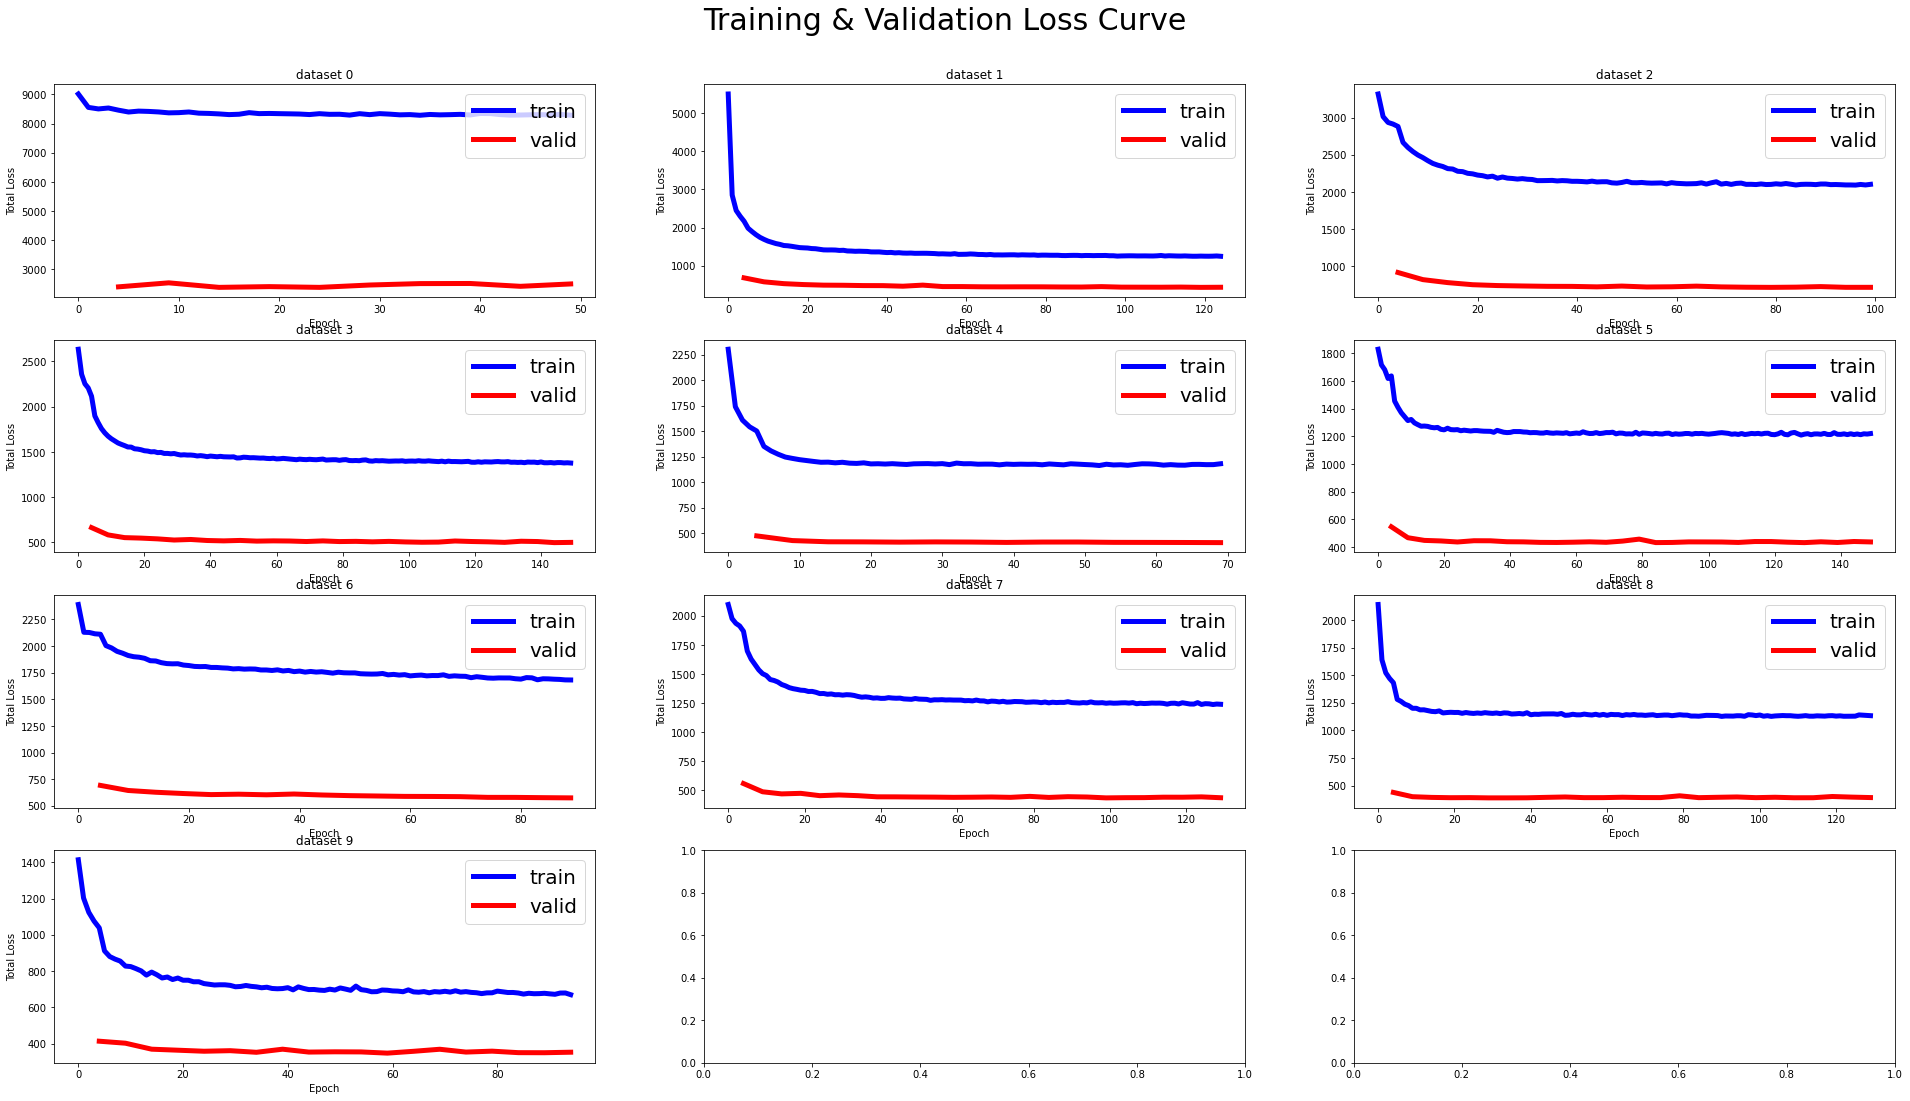

In [78]:
loss_plot(loss_dictC['train'], loss_dictC['valid'], num_row = 4, num_col = 3)
table_setC

#### regressor

In [18]:
runall_modelR = NeuralNetworkR().to(device)
runall_optimizerR = torch.optim.Adam(runall_modelR.parameters(), lr = 0.001, weight_decay = 0.001)
runall_criterionR = nn.MSELoss().to(device)

table_setR, loss_dictR = runall_nn(train_x = run_train_x, 
                                   train_y = run_train_y, 
                                   test_x = run_test_x, 
                                   test_y = run_test_y, 
                                   n_epoch = 150, 
                                   batch_size = 64,
                                   model = runall_modelR,
                                   optimizer = runall_optimizerR, 
                                   criterion = runall_criterionR, 
                                   filename = 'runhist_array_4criteria_NeuralNetworkR', 
                                   train_ratio = 0.75, 
                                   early_stop = 10,
                                   mode = 'R')

  0%|          | 0/10 [00:00<?, ?it/s]


Starting training Dataset 0:


  0%|          | 0/150 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x133 and 114x64)

In [ ]:
loss_plot(loss_dictR['train'], loss_dictR['valid'], num_row = 4, num_col = 3)
table_setR

### export

In [66]:
savedate = '20211109'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'NeuralNetwork'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'NeuralNetwork')